<a href="https://colab.research.google.com/github/abelowska/dataPy/blob/main/Classes_05_KNN_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear regressors: KNN and Decision Tree

Imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.preprocessing import power_transform

In [2]:
plt.rcParams["figure.figsize"] = (10,7)

In [3]:
# constans
test_size=0.2
random_state=42

In [7]:
def compute_score(y_true, y_pred):
  '''
  Helper function for printing scores.

  Parameters:
  y_true: ndarray of y values from original dataset.
  y_pred: ndarray of y values predicted with given model.

  Return:
  dictionary object that consists of R2 and median absolute error scores.

  '''
  return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedianAE": f"{median_absolute_error(y_true, y_pred):.3f}",
}

In [12]:
def plot_prediction_error(y_test, y_pred, scores):
  _, ax = plt.subplots(figsize=(5, 5))

  y_test = y_test.to_numpy() if isinstance(y_test, pd.DataFrame) else y_test

  display_ = PredictionErrorDisplay.from_predictions(
      y_test,
      y_pred,
      kind="actual_vs_predicted",
      ax=ax,
      scatter_kwargs={"alpha": 0.5}
  )

  ax.set_title("Linear model")
  for name, score in scores.items():
      ax.plot([], [], " ", label=f"{name}: {score}")
  ax.legend(loc="upper left")
  plt.tight_layout()

## Load dataset

In [4]:
df = pd.read_csv('data_neo-ffi_religion.csv')
df.head()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté
0,34.082439,46.043690,40.788554,461.110426,43.865868,2.838143,13.283297,3.744990,6.093860,4.458938
1,45.914894,45.968433,41.235290,401.384274,28.027017,3.824136,9.923179,3.392507,5.230517,3.269949
2,33.008654,42.065841,42.069170,390.193510,41.023889,2.288471,10.675467,3.765416,4.801786,4.683288
3,56.112153,45.903571,53.080369,468.518727,20.018578,5.824989,13.750513,2.826005,2.592473,0.883451
4,31.972346,49.009174,42.161417,508.686847,43.026028,4.038579,15.431653,4.689029,4.916692,4.627536


Inspect the dataset

In [6]:
df.describe()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,37.811238,42.318673,41.208357,436.675828,36.042290,3.880765,31.980561,4.883313,5.299550,4.223002
std,8.871624,7.222606,8.104708,63.642560,11.014191,1.259730,100.373810,0.778776,0.944093,1.392345
min,14.040682,21.008399,16.904128,289.257541,12.942666,0.876634,2.262785,1.304512,1.905408,0.801310
25%,32.079634,37.959417,35.084398,388.849925,27.908735,3.046971,5.510436,4.430331,4.729321,3.169300
50%,38.954182,43.089033,41.052187,440.203497,35.908038,3.762668,11.153706,4.922857,5.437686,4.434408
75%,43.946449,47.078293,47.089308,480.501705,44.692161,4.684792,28.066035,5.373428,5.981834,5.213640
max,56.882820,59.121317,59.000430,572.957659,60.030339,6.935906,1250.740428,6.877499,7.139185,7.151545


## K-Nearest Neighbours

Recall the model from the last classes:

*Orthodoxy ~ Extraversion + Agreeableness + Openness + Neuroticism + Conscientiousness*

So far, we modeled this relationship using linear regression. Let's take a look at how the non-linear estimator - KNN will manage to model this relationship.

To create a model with KNN estimator, you simply need to create an object of type [`KNeighborsRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) instead of the linear regression object. Give yourself a moment to read the documentation of KNN regressor.

### Exercise 1
Let's compare the performance of KNN to the linear model.

1. The first model is the simplest linear model we have already done - without transformation of our exponential y

In [10]:
# Linear regression model - for comparison
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of linear regression estimator
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.058', 'MedianAE': '21.663'}

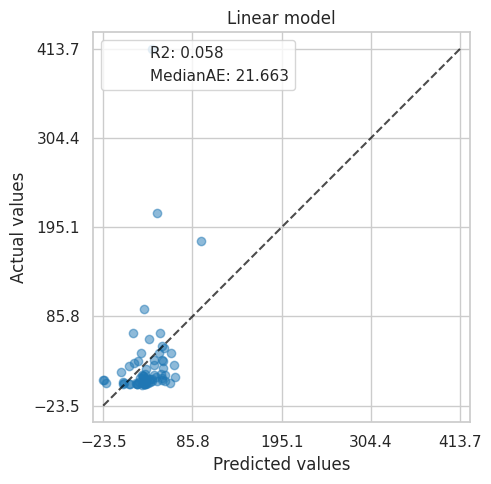

In [13]:
plot_prediction_error(y_test, y_pred, scores)

2. Linear model with y transformation (so that y has a more Gaussian-like distribution) - the best model we have already created:

In [15]:
# Linear regression model - for comparison
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

y_transformed = power_transform(y, method='box-cox')

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=test_size, random_state=random_state)

# create object of linear regression estimator
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.268', 'MedianAE': '0.751'}

In [ ]:
plot_prediction_error(y_test, y_pred, scores)

3. KNN Regressor model with default parameters (and no transformations at all):

In [121]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of KNN estimator
knn = KNeighborsRegressor(n_neighbors=2)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '0.722', 'MedianAE': '6.629'}

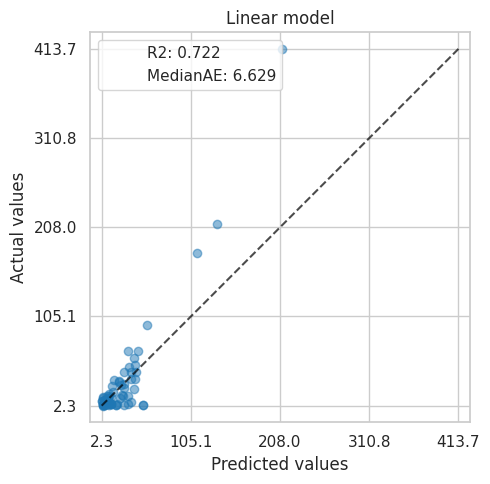

In [122]:
plot_prediction_error(y_test, y_pred, scores)

There is a huge difference! We didn't have to do anything - with zero knowledge of the data, we got a better result than using linear regression and all our knowledge of the data.

### Exercise 2
Now - try to play a little bit with KNN. Maybe you can extract even more from the model by changing its parameters?

Create at least 3 different KNN  and change at leat 2 different parameters.

In [ ]:
# your code here

### (Exercise 2.1)

Too complex models tend to overfit, i.e., they are too closely matched to the training data and begin to perform poorly on the test data.
Plot training and testing performance vs number of neighbors to see, whether this model tends to overfit when the number of neighbors increases.

In [78]:
# Your code here

What do you think this chart means for the problem of predicting orthodoxy based on personality traits? How many people with similar personality profiles is it best to look at to make a good prediction of the level of orthodoxy?

## Decision Trees

Now, we are going to create our model

*Orthodoxy ~ Extraversion + Agreeableness + Openness + Neuroticism + Conscientiousness*

using decision trees and compare this model to linear regression and KNN. Lets's take a look on the simples DT model.

In [87]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism']]

y = df[['Orthodoxy']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# create object of DT estimator
dt = # your code

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

scores = compute_score(y_test, y_pred)
scores

{'R2': '-10.755', 'MedianAE': '2.844'}

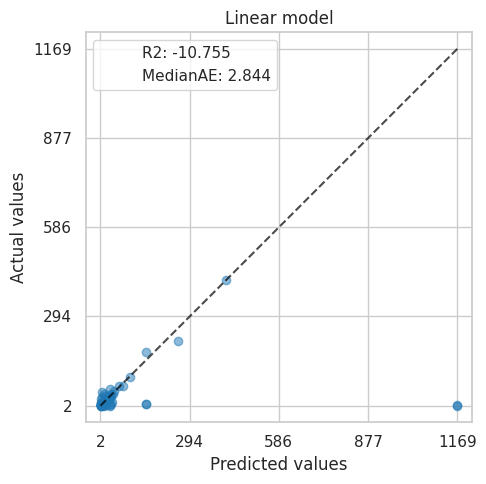

In [88]:
plot_prediction_error(y_test, y_pred, scores)

Ups! Something clearly is wrong. Does this graph remind you of anything?

### Exercise 3
Create the model with DT estimator, but before fitting, transform y to have more Gaussian-like distribution.

With KNNs exponential `y` wasn't a problem because the only thing KNN looked at was y value of nearest neighbors. DTs try to find the best-dividing lines for the data by assessing the quality of these divisions using the cost functions (and these functions base on the data variance). We need to 'fix' our variances - make them more comparable so that we can realize the full potential of decision trees.  

Create the model with a decision tree estimator, but transform `y` before the train-test split.

In [96]:
# Your code here

{'R2': '0.387', 'MedianAE': '0.189'}

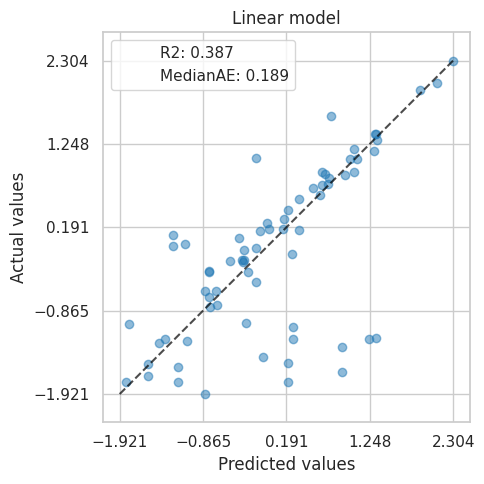

In [97]:
plot_prediction_error(y_test, y_pred, scores)

### (Exercise 3.1)

Decision trees have a lot of adjustable parameters. Especially interesting are: `criterion`, `max_depth`, `min_samples_split`, and `min_samples_leaf`. Read about them in the documentation (and in the internet) and see how the performance of the model changes with the change of various parameters. You may want to create a graph of performance from model complexity to see if decision trees overfit easily.

In [127]:
# Your code here

### Exercise 4

And now - the most interesting thing! We can analyze the structure of our fitted decision tree. We have to save the tree into `.dot` file and then we can use the [WebGraphviz](http://www.webgraphviz.com) tool to visualize the tree. You should copy the content of the `.dot` file (saved to the *Files* directory in Colab) to the input area on the [WebGraphviz](http://www.webgraphviz.com).

In [98]:
from sklearn.tree import export_graphviz
# export the decision tree model to a tree_structure.dot file
# paste the contents of the file to webgraphviz.com
export_graphviz(
    dt,
    out_file ='tree_structure.dot',
    feature_names = X.columns.to_numpy()
)

Do the conclusions drawn from the linear regression coincide with DT?

## Homework: Comaprison of linear regression, KNN and Decision Tree

Check the effect of scaling and data transformation on Gaussian distributions on the performance of all three models.
* Models can be compared e.g., in three places: raw dataset, after y-transformation and after X-scaling;
* Create a visual comparison for all three estimators;
* Compare the models' estimated parameters (or structures) to see if the interpretation of the model has changed. For KNN, you can use [`kneighbors()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.kneighbors) method that returns neighbors of a given (of your choice) sample (of course these neighbors are from the training dataset). [`kneighbors()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.kneighbors) returns the distance of input point from each of n neighbors and indexes of those neighbors. You can always select these samples from the `X_train` dataset to see if your point and its neighbors are indeed closely related.